In [16]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline


## Exploratory Data Analysis and Building a model for relationship between greenhouse gas emissions from a car and that car's features

We've collected the data, cleaned it up -- now let's build a model!

### Step 1: Prepare dataframe for developing linear regression model
*Edit and add features as needed for desired model*

-

Open the `all_cars_eda` pickled dataframe with all cars data

In [17]:
with open('pickles/all_cars_eda.pickle','rb') as read_file:
    all_cars_eda = pickle.load(read_file)

-

Create binned categories for `years` based on the year timeframes that the EPA developed national regulations for cars' greenhouse gas emissions:
- 1984 - 2011: 'pre' strict regulations around emissions
- 2012 - 2021: implementation of regulations around emissions.  Note that regulations were 'loosened' by EPA starting with 2021 models, which will be interesting to analyze in coming years, but as of now (July 2020) there are only 36 cars of the 'year' 2021 so data in that category would not yield reliable insights or value.  For now, will remain in regulations bucket since 2021 cars are still under more regulations than prior to 2012

In [18]:
all_cars_eda['year_range'] = ['year_pre_regulations' if
                              year in [1984, 1985, 1986, 
                                       1987, 1988, 1989, 
                                       1990, 1991, 1992, 
                                       1993, 1994, 1995, 
                                       1996, 1997, 1998, 
                                       1999, 2000, 2001,
                                       2002, 2003, 2004,
                                       2005, 2006, 2007,
                                       2008, 2009, 2010,
                                       2011]
                              
                              else 'year_regulations' if 
                              year in [2012,2013,2014,2015,
                                       2016,2017,2018,2019,
                                       2020,2021]           
                              
                              else np.nan for year in all_cars_eda['year']]

Note that we now only have 36 samples in the `year_post_regulations` so will not be enough to draw reliable conclusions from.  But will keep in for now to see any indictation of direction greenhouse gases will take 2021 and beyond >>

In [19]:
all_cars_eda.year_range.value_counts()

year_pre_regulations    3553
year_regulations        1707
Name: year_range, dtype: int64

-

**REMOVING FEATURES**

**Removing miles-per-gallon - `mpg`.**  By removing we'll allow opportunity to examine any relationships between the other features of the car and the greenhouse gas emissions, otherwise miles-per-gallon would be too dominant of feature and also isn't really telling us more deeply what causes greenhouse gas emissions from the mechanics of how the car was built

**Removing `make`, `model`, & `trans_speed`.**  Can say with confidence these are not signiciantly relevant to the greenhouse gas emissions of the car and would not be worth create dummies for the non-numberic categories.

**Removing `year`.**  Will just use the dummy columns created for years.

In [20]:
del all_cars_eda['mpg']
del all_cars_eda['make']
del all_cars_eda['model']
del all_cars_eda['trans_speed']
del all_cars_eda['year']

Verify everything looks okay >>

In [21]:
all_cars_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5260 entries, 0 to 5264
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   capacity_liters  5260 non-null   float64
 1   cylinders        5260 non-null   int32  
 2   transmission     5260 non-null   object 
 3   fuel_type        5260 non-null   object 
 4   gg_emissions     5260 non-null   float64
 5   year_range       5260 non-null   object 
dtypes: float64(2), int32(1), object(3)
memory usage: 267.1+ KB


-

Create the dummies for the features that are objects and then rename columns with proper formatting to work later in graphing code >>

In [25]:
all_cars_eda = pd.get_dummies(all_cars_eda)

In [26]:
all_cars_eda.columns

Index(['capacity_liters', 'cylinders', 'gg_emissions',
       'transmission_Automatic', 'transmission_Manual', 'fuel_diesel',
       'fuel_premium', 'fuel_regular', 'year_pre_regulations',
       'year_regulations'],
      dtype='object')

In [27]:
all_cars_eda.rename(columns = {'fuel_type_Premium Gasoline': 'fuel_premium',
                               'fuel_type_Regular Gasoline': 'fuel_regular',
                               'fuel_type_Diesel': 'fuel_diesel',
                               'year_range_year_pre_regulations': 'year_pre_regulations',
                               'year_range_year_regulations': 'year_regulations'
                              },
                    inplace = True)

### Step 2: Exploratory Data Analysis

#### CORRELATION

Examine the correlations of all the values>>

In [28]:
all_cars_eda.corr()

,capacity_liters,cylinders,gg_emissions,transmission_Automatic,transmission_Manual,fuel_diesel,fuel_premium,fuel_regular,year_pre_regulations,year_regulations
capacity_liters,1.000000,0.906330,0.773934,0.264746,-0.264746,0.126013,0.135443,-0.199060,0.149540,-0.149540
cylinders,0.906330,1.000000,0.740521,0.309784,-0.309784,0.064916,0.253522,-0.276253,0.105251,-0.105251
gg_emissions,0.773934,0.740521,1.000000,0.169507,-0.169507,-0.010432,0.117899,-0.105576,0.343847,-0.343847
transmission_Automatic,0.264746,0.309784,0.169507,1.000000,-1.000000,-0.058951,0.196403,-0.152445,-0.361508,0.361508
transmission_Manual,-0.264746,-0.309784,-0.169507,-1.000000,1.000000,0.058951,-0.196403,0.152445,0.361508,-0.361508
fuel_diesel,0.126013,0.064916,-0.010432,-0.058951,0.058951,1.000000,-0.198311,-0.376113,0.046135,-0.046135
fuel_premium,0.135443,0.253522,0.117899,0.196403,-0.196403,-0.198311,1.000000,-0.833584,-0.262578,0.262578
fuel_regular,-0.199060,-0.276253,-0.105576,-0.152445,0.152445,-0.376113,-0.833584,1.000000,0.222227,-0.222227
year_pre_regulations,0.149540,0.105251,0.343847,-0.361508,0.361508,0.046135,-0.262578,0.222227,1.000000,-1.000000
year_regulations,-0.149540,-0.105251,-0.343847,0.361508,-0.361508,-0.046135,0.262578,-0.222227,-1.000000,1.000000


-

Now narrow in on just the greenhouse gas emissions column (the 'y') to examine the value of greatest interest more easily >>

In [29]:
(all_cars_eda.corr()).iloc[:,2]

capacity_liters           0.773934
cylinders                 0.740521
gg_emissions              1.000000
transmission_Automatic    0.169507
transmission_Manual      -0.169507
fuel_diesel              -0.010432
fuel_premium              0.117899
fuel_regular             -0.105576
year_pre_regulations      0.343847
year_regulations         -0.343847
Name: gg_emissions, dtype: float64

-

Now create a heatmap to help look at the relationships of the values >>

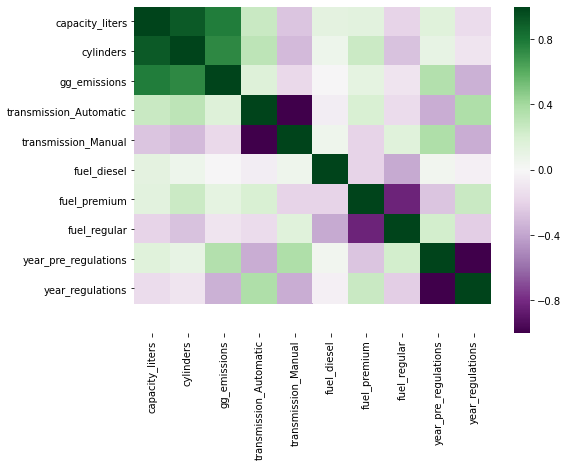

In [30]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(all_cars_eda.corr(), cmap="PRGn")
ax.set_ylim(11.0, 0)

plt.savefig('images/heatmap_correlation_gge.jpg', bbox_inches="tight")
plt.savefig('images/heatmap_correlation_gge.svg', bbox_inches="tight");

And now a Greenhouse Gas Emissions correlation matrix

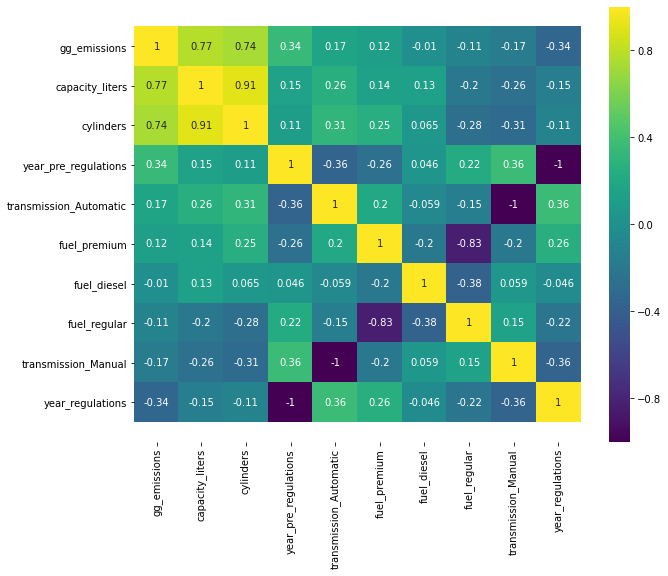

In [31]:
k = 11
cols = all_cars_eda.corr().nlargest(k, 'gg_emissions')['gg_emissions'].index
cm = all_cars_eda[cols].corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm, annot=True, cmap = 'viridis')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig('images/correlation_matrix_gge.jpg', bbox_inches="tight")
plt.savefig('images/correlation_matrix_gge.svg', bbox_inches="tight");

Create a pair plot for a deeper look at relationship between all features and variable >>

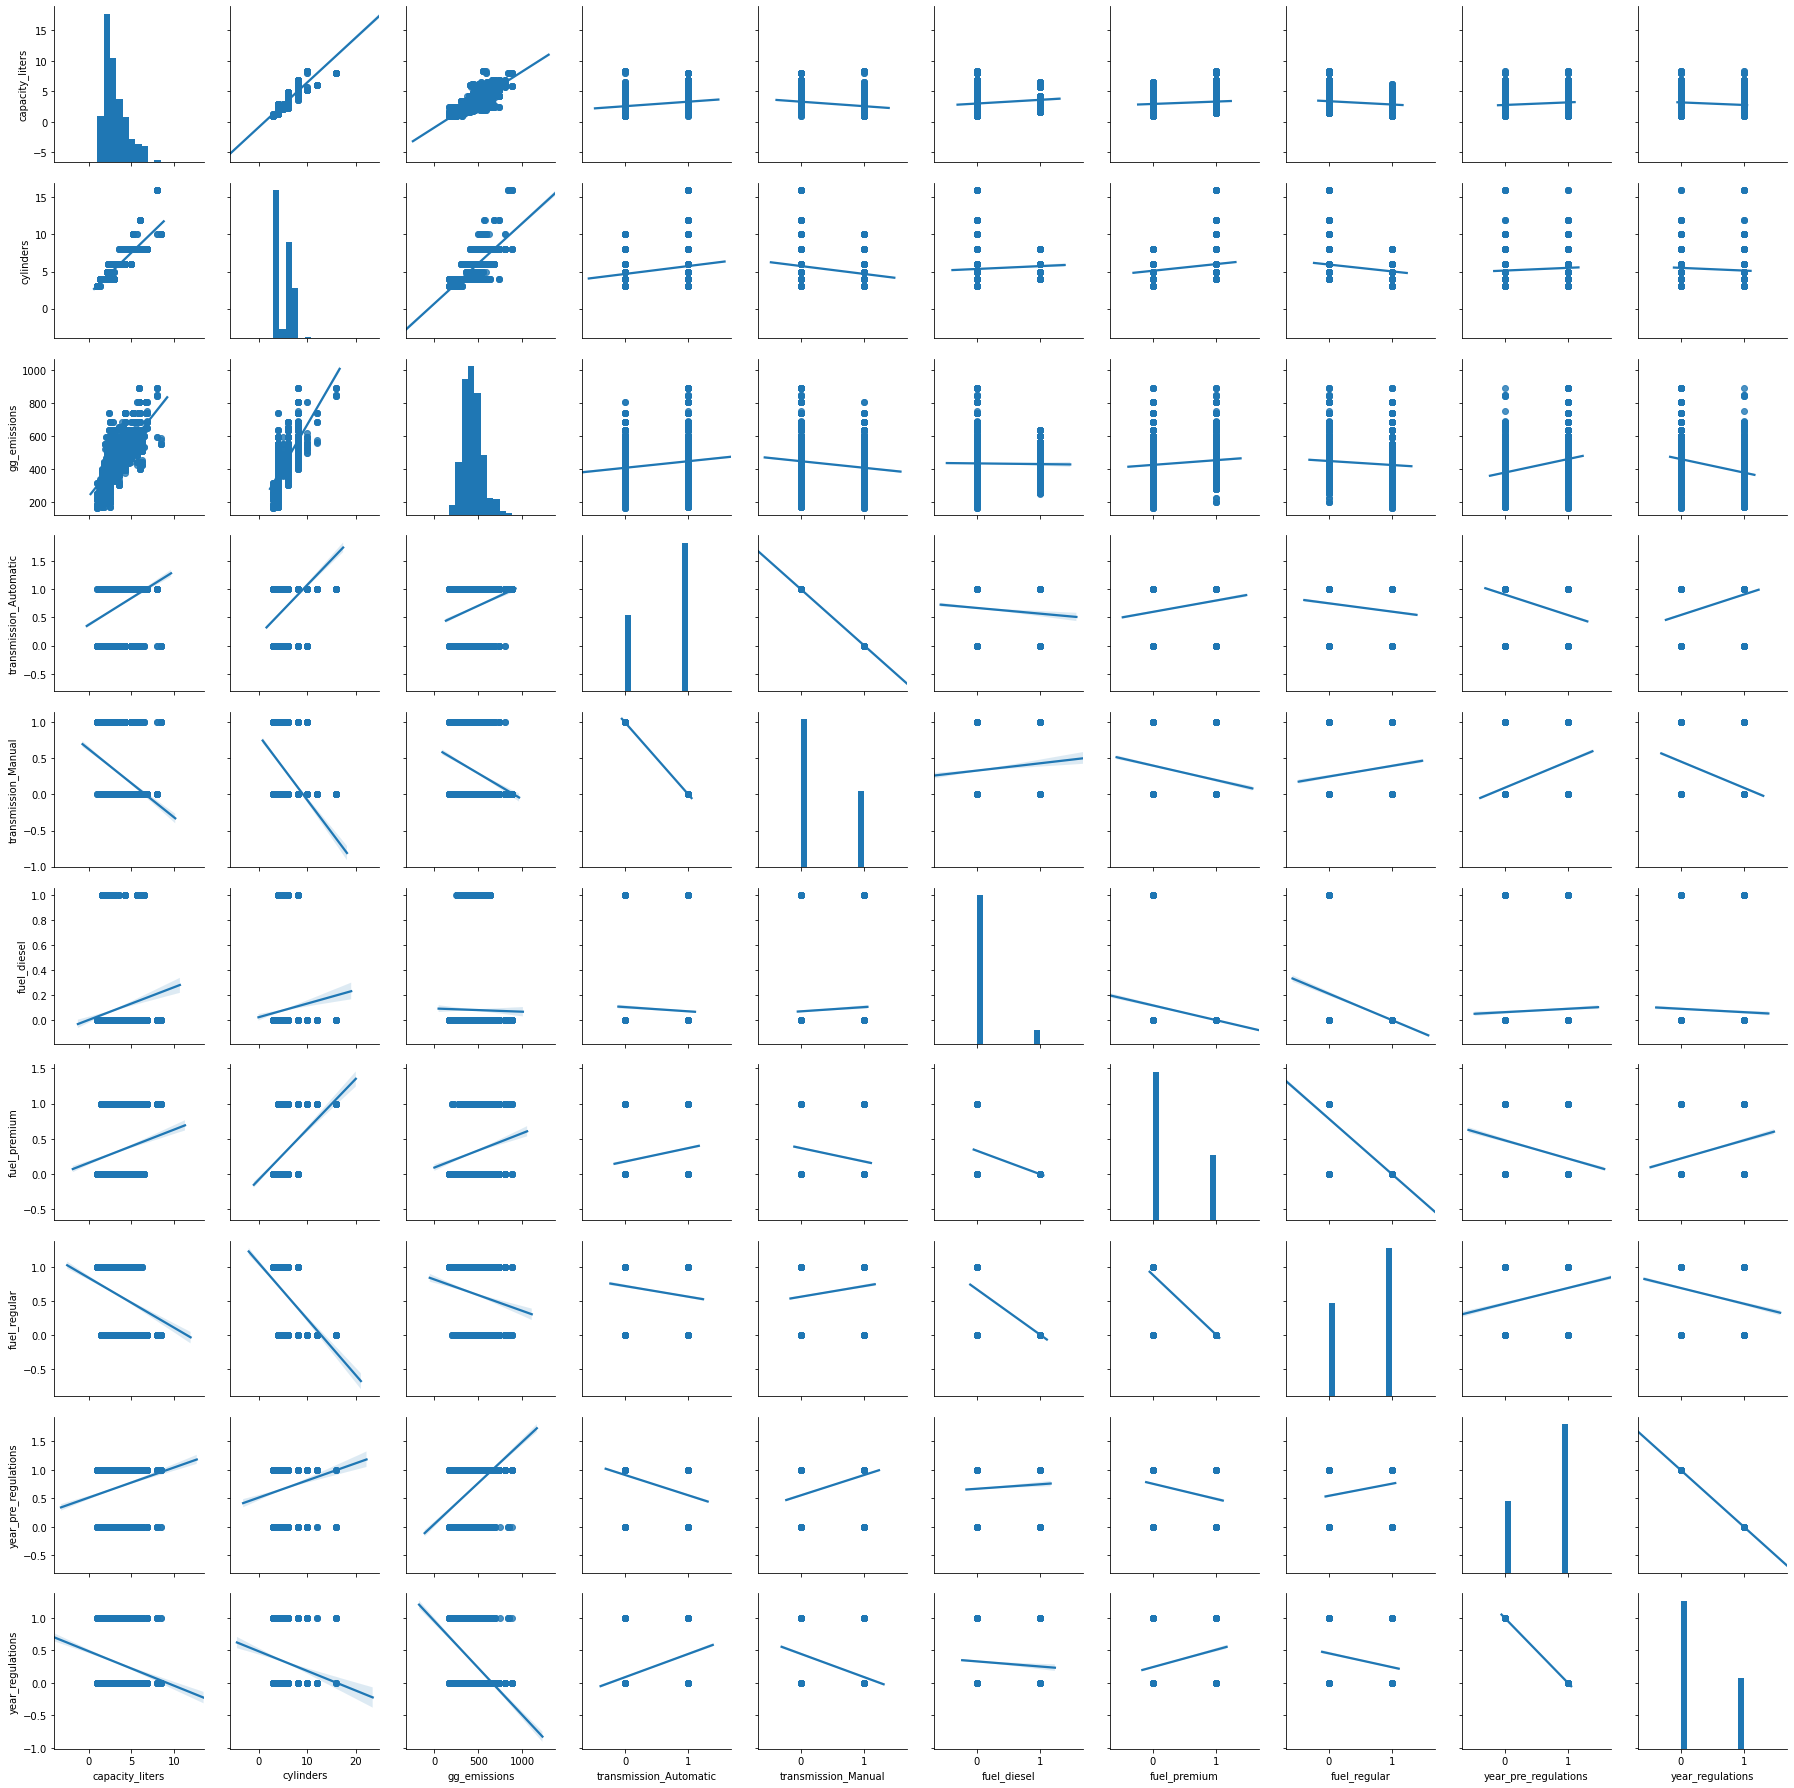

In [33]:
sns.pairplot(all_cars_eda, kind='reg')

plt.savefig('images/pairplot_gge.jpg', bbox_inches="tight")
plt.savefig('images/pairplot_gge.svg', bbox_inches="tight");

#### OUTLIERS EXAMINATION

For our non-dummied features, we'll look at their outliers (dummies can be ignored) >>

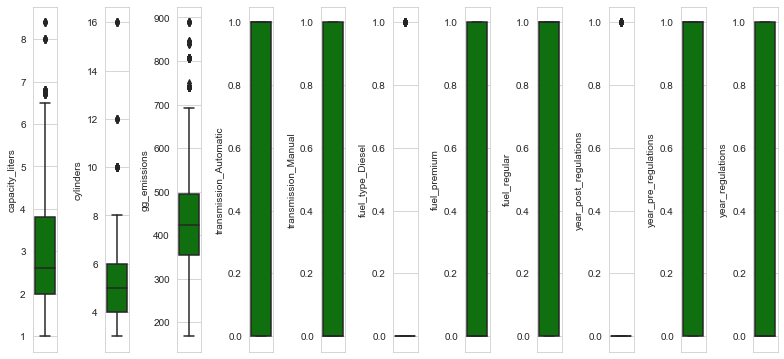

In [112]:
l = all_cars_eda.columns.values
number_of_columns=11
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(all_cars_eda[l[i]],color='green',orient='v')
    plt.tight_layout()
    
plt.savefig('images/boxplot_outliers.jpg', bbox_inches="tight")
plt.savefig('images/boxplot_outliers.svg', bbox_inches="tight");

#### CHECK DISTRIBUTION SKEWNESS

Again for our non-dummied features, we'll look at their skewness (dummies can be ignored) >>

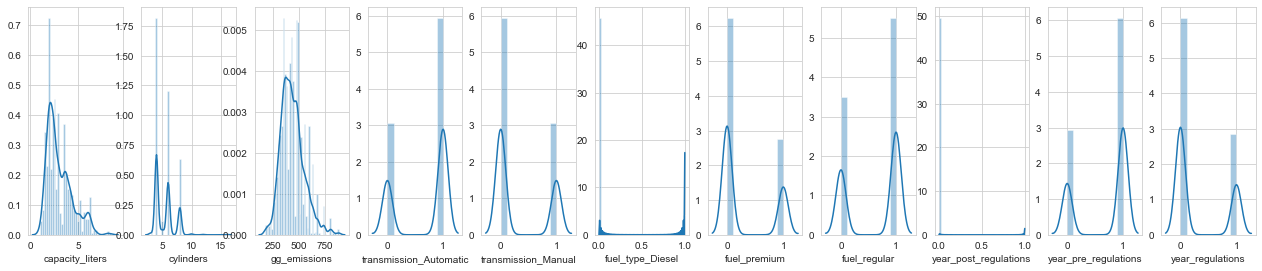

In [113]:
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(all_cars_eda[l[i]],kde=True)

### STEP 3: BUILD THE MODEL

Reducting to features that critical and not conditional on each other >>

In [133]:
# Define the model for greenhouse gas emissions of cars
cars_model = smf.ols('''gg_emissions ~ capacity_liters + cylinders 
              + transmission_Automatic + fuel_premium + year_regulations''',
                     data=all_cars_eda)

# Fit the model
cars_fit = cars_model.fit()

# Print summary statistics of the model's performance
cars_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gg_emissions   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     2102.
Date:                Mon, 13 Jul 2020   Prob (F-statistic):               0.00
Time:                        15:58:39   Log-Likelihood:                -29375.
No. Observations:                5260   AIC:                         5.876e+04
Df Residuals:                    5254   BIC:                         5.880e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                231.3295      3.542     65.314      0.000     224.386     238.273
capacity_liters           44.8630      1.640     27.349      0.000      41.647      48.079
cylinders                 13.8839      1.376     10.091      0.000      11.187      16.581
transmission_Automatic    12.0727      2.160      5.588      0.000       7.837      16.308
fuel_premium              13.4093      2.135      6.280      0.000       9.224      17.595
year_regulations         -65.0579      2.185    -29.778      0.000     -69.341     -60.775
==============================================================================
Omnibus:                      385.730   Durbin-Watson:                   0.343
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              880.773
Skew:                           0.461   Prob(JB):                    5.53e-192
Kurtosis:                       4.780   Cond. No.                         28.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-

#### PLOT THE RESIDUALS VS FITTED VALUES

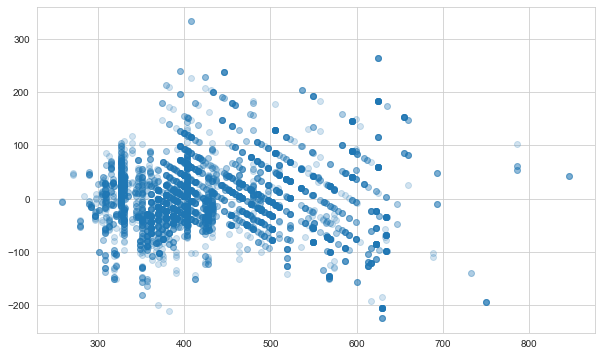

In [124]:
plt.figure(figsize=(10,6))
plt.scatter(cars_fit.predict(), cars_fit.resid, alpha=0.2);

#### USE SKLEARN TO GET MODEL STATS - SHOULD MATCH ABOVE

*Only used as test to verify different method to get values works*

In [119]:
# Create an empty model
cars_lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
X = all_cars_eda.loc[:, ['capacity_liters', 'cylinders', 'transmission_Automatic', 
                         'transmission_Manual', 'fuel_type_Diesel','fuel_premium',
                         'fuel_regular','year_pre_regulations','year_regulations',
                         'year_post_regulations'
                        ]]

# Identify the response variable
y = all_cars_eda.loc[:, ['gg_emissions']]

# Fit the model to the full dataset
cars_lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
print(f'R^2: {cars_lr.score(X,y)}')
print('\n')
print(f'Intercept: {cars_lr.intercept_}')
print('\n')
print(f'Coefficients: {cars_lr.coef_}')

R^2: 0.677770017963495


Intercept: [185.22478499]


Coefficients: [[ 46.69872579  13.19020649   5.83753711  -5.83753711 -28.73567893
   18.90354382   9.83213511  45.44074144 -19.52827345 -25.91246799]]
